## MyDailyImpact - Analysis and prediction of carbonfootprint in total and for each person

With the MayDailyImpact app, users worldwide can recognise the impact of their plant-based diet in terms of saving CO2, water, land and animal life. In addition to specifying which plant-based meal they have eaten (breakfast, lunch or dinner), they can enter the recipe name and add notes.

**As every individual impact counts towards strengthening the environment, recognising whether a user will use the app in the future or leave it is hugely important. With machine learning predictions based on user behaviour and other parameters, predictive measures could be taken to further motivate the users and prevent them from leaving.**

A marketing team could, for example, use these predictions to send motivational emails or push messages to users.

**As the app is not yet online, we created our own data set for the analysis with the kind support of the mentor Zubin John:** synthetic_activity_dataset-v0.csv

In the future, real data can then be incorporated into the analysis, thereby improving results.

## Recipe Dataset Creation:

The following steps were taken:

We define 50 unique dish names and a mapping of ingredients to possible plant-based substitutes.
For each dish, we generate a non-empty list of 3–6 ingredients.
For each ingredient, we assign a random portion size (in grams) and a random carbon footprint value (kg CO₂e).
The substitutions list is aligned with the ingredients list (using a substitute when available, or None).
This will need to be fixed in the future. Ingredient lists are not realistic.

## Activity Log Generation:

The following steps were taken:

Six personas are defined with specific parameters (e.g., record count, weight/height ranges, home country, dish preferences, meal type distribution, and substitution probability).
For each record, a unique record_id, user profile fields, and a timestamp (within a meal-type-specific time window over the past 2 years) are generated.
A recipe is sampled from the recipe dataset (filtered by dish preferences when possible), and its fields are assigned to the record.
Additional fields like substitutions_made, hunger_rating, meal_rating, and geo_location are also generated.
This process creates a complete activity log record with all 16 fields.

In [62]:
# Anna von Bank 01.03.2025
# Code for carbonfootprint_forecast

# -----------------------------
# CREATING THE DATA
# -----------------------------


import pandas as pd
import random
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# STEP 1: Create the Recipe Dataset
# -----------------------------

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Mapping for ingredient substitutions: if None, then no substitution available.
substitution_mapping = {
    "chicken": "tofu",  # chicken -> tofu
    "beef": "seitan",  # beef -> seitan
    "pork": "jackfruit",  # pork -> jackfruit
    "fish": "tempeh",  # fish -> tempeh
    "milk": "almond milk",  # milk -> almond milk
    "egg": "flax egg",  # egg -> flax egg
    "cheese": "vegan cheese",  # cheese -> vegan cheese
    "yogurt": "coconut yogurt",  # yogurt -> coconut yogurt
    # Already plant-based or neutral ingredients
    "pepper": None,
    "salt": None,
    "onion": None,
    "garlic": None,
    "tomato": None,
    "rice": None,
    "pasta": None,
    "quinoa": None,
    "spinach": None,
    "broccoli": None,
    "mushroom": None,
    "tofu": None,
}

# List of 50 unique dish names
dish_names = [
    "Protein Pasta",
    "Grilled Chicken Salad",
    "Vegan Buddha Bowl",
    "Simple Pasta",
    "Zucchini Noodles",
    "Local Curry",
    "Quinoa Salad",
    "Beef Stir-Fry",
    "Ramen with Veggies",
    "Stir-fried Rice",
    "Smoothie Bowl",
    "Mushroom Risotto",
    "Jackfruit Tacos",
    "Seitan Sandwich",
    "Tofu Stir-Fry",
    "Vegan Wrap",
    "Tempeh Salad",
    "Almond Milk Porridge",
    "Flax Egg Omelette",
    "Vegan Pizza",
    "Chickpea Curry",
    "Vegan Burrito",
    "Veggie Burger",
    "Vegan Pasta",
    "Spinach Lasagna",
    "Tofu Scramble",
    "Vegan Pancakes",
    "Miso Soup",
    "Vegan Chili",
    "Vegan Sushi",
    "Quinoa Bowl",
    "Vegan Pad Thai",
    "Vegan Korma",
    "Grilled Veggie Skewers",
    "Vegan Hotpot",
    "Vegetable Stir-Fry",
    "Vegan Casserole",
    "Vegan Shepherd’s Pie",
    "Vegan Risotto",
    "Vegan Curry",
    "Tofu Tacos",
    "Vegan Empanadas",
    "Vegan Mac & Cheese",
    "Vegan Burrito Bowl",
    "Vegan Wrap",
    "Vegan Fajitas",
    "Vegan Quesadilla",
    "Vegan Gnocchi",
    "Vegan Paella",
]


# Function to generate a random list of ingredients (3 to 6 ingredients)
def generate_ingredients():
    possible_ingredients = list(substitution_mapping.keys())
    num = random.randint(3, 6)
    return random.sample(possible_ingredients, num)


# For each ingredient list, generate:
# - portion_size: list of integers (grams)
# - substitutions_list: aligned with ingredients_list (using mapping; if None, then no substitution)
# - carbon_footprint_original: a random float value representing kg CO₂e for the ingredient.
def process_ingredients(ing_list):
    portion_sizes = [random.randint(50, 300) for _ in ing_list]
    subs_list = []
    carbon_footprint = []
    for ing in ing_list:
        sub = substitution_mapping.get(ing, None)
        subs_list.append(sub)
        # If substitution exists, assign a random carbon footprint value; else still assign a value.
        # Here we assume each ingredient has a carbon footprint; substitution availability does not change that.
        footprint = round(random.uniform(0.1, 5.0), 2)
        carbon_footprint.append(footprint)
    return portion_sizes, subs_list, carbon_footprint


# Generate 50 recipes
recipes = []
for dish in dish_names:
    ings = generate_ingredients()
    portions, subs, footprint = process_ingredients(ings)
    recipe_record = {
        "dish_name": dish,
        "ingredients_list": ings,
        "portion_size": portions,  # in grams, aligned with ingredients_list
        "substitutions_list": subs,  # aligned with ingredients_list
        "carbon_footprint_original": footprint,  # kg CO₂e per ingredient, aligned with ingredients_list
    }
    recipes.append(recipe_record)

df_recipes = pd.DataFrame(recipes)
# print(df_recipes)  # Uncomment to inspect the recipe dataset

# -----------------------------
# STEP 2: Generate Activity Logs for Each Persona
# -----------------------------

# Define persona parameters in a dictionary
personas = {
    "Hardcore Henrietta": {
        "user_id": "Hardcore Henrietta",
        "num_records": 350,
        "weight_range": (75, 85),
        "height_range": (165, 175),
        "home_country": "Germany",
        "home_coords": (52.5200, 13.4050),  # Berlin
        "dish_preferences": ["Protein Pasta", "Beef Stir-Fry"],
        "meal_type_weights": {"Breakfast": 0.30, "Lunch": 0.35, "Dinner": 0.35},
        "substitution_prob": 0.35,
        "hunger_mean": 3.75,
        "meal_rating_mean": 4.25,
    },
    "Fit Felix": {
        "user_id": "Fit Felix",
        "num_records": 300,
        "weight_range": (70, 75),
        "height_range": (175, 180),
        "home_country": "Netherlands",
        "home_coords": (52.3676, 4.9041),  # Amsterdam
        "dish_preferences": ["Grilled Chicken Wrap", "Quinoa Salad"],
        "meal_type_weights": {"Breakfast": 0.40, "Lunch": 0.30, "Dinner": 0.30},
        "substitution_prob": 0.50,
        "hunger_mean": 3.0,
        "meal_rating_mean": 4.0,
    },
    "Vegan Vera": {
        "user_id": "Vegan Vera",
        "num_records": 250,
        "weight_range": (55, 60),
        "height_range": (165, 170),
        "home_country": "Sweden",
        "home_coords": (59.3293, 18.0686),  # Stockholm
        "dish_preferences": ["Vegan Buddha Bowl", "Quinoa Salad"],
        "meal_type_weights": {"Breakfast": 0.33, "Lunch": 0.33, "Dinner": 0.34},
        "substitution_prob": 0.15,
        "hunger_mean": 2.75,
        "meal_rating_mean": 4.25,
    },
    "Budget Billie": {
        "user_id": "Budget Billie",
        "num_records": 250,
        "weight_range": (58, 62),
        "height_range": (163, 167),
        "home_country": "India",
        "home_coords": (12.9716, 77.5946),  # Bangalore
        "dish_preferences": ["Simple Pasta", "Ramen with Veggies", "Stir-fried Rice"],
        "meal_type_weights": {"Breakfast": 0.25, "Lunch": 0.40, "Dinner": 0.35},
        "substitution_prob": 0.20,
        "hunger_mean": 4.0,
        "meal_rating_mean": 3.25,
    },
    "Diet Dani": {
        "user_id": "Diet Dani",
        "num_records": 350,
        "weight_range": (78, 82),
        "height_range": (168, 172),
        "home_country": "Italy",
        "home_coords": (41.9028, 12.4964),  # Rome
        "dish_preferences": ["Grilled Chicken Salad", "Zucchini Noodles", "Smoothie Bowl"],
        "meal_type_weights": {"Breakfast": 0.35, "Lunch": 0.30, "Dinner": 0.35},
        "substitution_prob": 0.45,
        "hunger_mean": 3.0,
        "meal_rating_mean": 3.75,
    },
    "Travel Terry": {
        "user_id": "Travel Terry",
        "num_records": 400,
        "weight_range": (75, 80),
        "height_range": (178, 182),
        "home_country": "Japan",
        "home_coords": (35.6895, 139.6917),  # Tokyo (home base)
        "dish_preferences": None,  # diverse, use any dish from dataset
        "meal_type_weights": {"Breakfast": 0.30, "Lunch": 0.35, "Dinner": 0.35},
        "substitution_prob": 0.50,
        "hunger_mean": 4.0,
        "meal_rating_mean": 3.75,
    },
}

# Define meal time ranges (hours) for each meal type
meal_time_ranges = {"Breakfast": (7, 9), "Lunch": (12, 14), "Dinner": (18, 20)}

# For Travel Terry, define a list of travel destination coordinates (besides home base)
travel_destinations = [
    (48.8566, 2.3522),  # Paris
    (40.7128, -74.0060),  # New York
    (-33.8688, 151.2093),  # Sydney
]


# Function to generate a random timestamp within the past 2 years, adjusted to meal_type hours.
def generate_timestamp(meal_type):
    now = datetime.now()
    two_years_ago = now - timedelta(days=730)
    # Random date between two_years_ago and now
    random_date = two_years_ago + (now - two_years_ago) * random.random()
    # Set hour based on meal type's range
    start_hour, end_hour = meal_time_ranges[meal_type]
    hour = random.randint(start_hour, end_hour)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    random_date = random_date.replace(hour=hour, minute=minute, second=second, microsecond=0)
    return random_date


# Function to sample a rating (1-5) given a mean, with a small standard deviation.
def sample_rating(mean, sd=0.5):
    rating = int(round(np.clip(random.gauss(mean, sd), 1, 5)))
    return rating


# Function to sample a geo_location based on home_coords with slight noise.
def sample_geo_location(persona_name, home_coords):
    if persona_name == "Travel Terry":
        # 50% chance to use home base, else a random travel destination.
        base = home_coords if random.random() < 0.5 else random.choice(travel_destinations)
    else:
        base = home_coords
    lat_noise = random.uniform(-0.02, 0.02)
    lon_noise = random.uniform(-0.02, 0.02)
    return (round(base[0] + lat_noise, 4), round(base[1] + lon_noise, 4))


# -----------------------------
# STEP 3: Generate Activity Logs
# -----------------------------
activity_logs = []
record_counter = 1

for persona, params in personas.items():
    for i in range(params["num_records"]):
        # Identification & User Profile Fields
        record_id = f"rec_{record_counter:05d}"
        user_id = params["user_id"]
        weight = round(random.uniform(*params["weight_range"]), 1)
        height = round(random.uniform(*params["height_range"]), 1)
        country = params["home_country"]

        # Choose meal type based on weighted probabilities
        meal_types = list(params["meal_type_weights"].keys())
        weights_list = list(params["meal_type_weights"].values())
        meal_type = random.choices(meal_types, weights=weights_list, k=1)[0]

        # Generate timestamp for the record based on meal_type hours
        activity_timestamp = generate_timestamp(meal_type)

        # Recipe selection:
        # If persona has dish preferences, filter recipes by matching dish name keywords.
        if params["dish_preferences"]:
            preferred_recipes = df_recipes[
                df_recipes["dish_name"].str.contains(
                    "|".join(params["dish_preferences"]), case=False
                )
            ]
            if len(preferred_recipes) > 0:
                recipe = preferred_recipes.sample(n=1).iloc[0]
            else:
                recipe = df_recipes.sample(n=1).iloc[0]
        else:
            recipe = df_recipes.sample(n=1).iloc[0]

        # Meal & Ingredient Details from the recipe
        dish_name = recipe["dish_name"]
        ingredient_list = recipe["ingredients_list"]
        portion_size = recipe["portion_size"]
        substitutions_list = recipe["substitutions_list"]
        carbon_footprint_original = recipe["carbon_footprint_original"]

        # Determine if substitutions were made based on persona's substitution probability.
        substitutions_made = 1 if random.random() < params["substitution_prob"] else 0

        # Sample User Feedback Fields: hunger_rating and meal_rating
        hunger_rating = sample_rating(params["hunger_mean"])
        meal_rating = sample_rating(params["meal_rating_mean"])

        # Sample geo_location based on persona's home coordinates
        geo_location = sample_geo_location(user_id, params["home_coords"])

        # Construct the activity log record with all 16 fields.
        record = {
            "record_id": record_id,
            "user_id": user_id,
            "activity_timestamp": activity_timestamp,
            "weight": weight,
            "height": height,
            "country_of_residence": country,
            "dish_name": dish_name,
            "meal_type": meal_type,
            "ingredient_list": ingredient_list,
            "substitutions_list": substitutions_list,
            "substitutions_made": substitutions_made,
            "carbon_footprint_original": carbon_footprint_original,
            "portion_size": portion_size,
            "hunger_rating": hunger_rating,
            "meal_rating": meal_rating,
            "geo_location": geo_location,
        }

        activity_logs.append(record)
        record_counter += 1

# Convert the activity logs into a DataFrame.
df_activity = (
    pd.DataFrame(activity_logs)
    .sort_values(by="activity_timestamp", ascending=True)
    .reset_index(drop=True)
)
print(df_activity.describe())

# Verify that the dataset has 16 fields and print a sample.
print("Columns in the dataset (should be 16):", list(df_activity.columns))
print(df_activity.info())

# Sort activity records by timestamp
# df_activity.to_csv("ds/data/synthetic_activity_dataset-v0.csv", index=False)


                  activity_timestamp       weight       height  \
count                           1900  1900.000000  1900.000000   
mean   2024-03-01 09:19:24.257894912    72.676789   172.247053   
min              2023-03-02 12:42:09    55.000000   163.000000   
25%    2023-09-05 05:10:34.249999872    61.700000   167.600000   
50%              2024-02-27 20:02:19    76.300000   170.800000   
75%    2024-08-28 18:33:57.750000128    79.400000   178.200000   
max              2025-02-28 13:55:09    85.000000   182.000000   
std                              NaN     8.889483     5.636173   

       substitutions_made  hunger_rating  meal_rating  
count         1900.000000    1900.000000  1900.000000  
mean             0.372632       3.450000     3.876316  
min              0.000000       1.000000     2.000000  
25%              0.000000       3.000000     3.000000  
50%              0.000000       3.000000     4.000000  
75%              1.000000       4.000000     4.000000  
max          

## Exploratory Data Analysis (EDA)

The first step is a structured **Exploratory Data Analysis (EDA)** for the generated dataset.  
The main goal is to understand the dataset, clean the data, compute **carbon footprint savings**, and visualize key insights.  


**Basic Data Information**

Before performing any data transformations, we inspect the dataset:  


In [63]:
# ---------------------------
# 1. BASIC DATA INFORMATION
# ---------------------------
import seaborn as sns
print("\n🔍 Basic Dataset Information:")
print(df_activity.info())

print("\n📌 First 5 Rows of Dataset:")
print(df_activity.head())

# Check for missing values
missing_values = df_activity.isnull().sum()
print("\n❗ Missing Values in Dataset:")
print(missing_values[missing_values > 0])

# Check unique users & meals
print(f"\n👤 Unique Users: {df_activity['user_id'].nunique()}")
print(f"🍽️ Unique Dishes: {df_activity['dish_name'].nunique()}")




🔍 Basic Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   record_id                  1900 non-null   object        
 1   user_id                    1900 non-null   object        
 2   activity_timestamp         1900 non-null   datetime64[ns]
 3   weight                     1900 non-null   float64       
 4   height                     1900 non-null   float64       
 5   country_of_residence       1900 non-null   object        
 6   dish_name                  1900 non-null   object        
 7   meal_type                  1900 non-null   object        
 8   ingredient_list            1900 non-null   object        
 9   substitutions_list         1900 non-null   object        
 10  substitutions_made         1900 non-null   int64         
 11  carbon_footprint_original  1900 non-nul

**Data Cleaning**

We ensure data consistency by performing the following:

Convert timestamps to datetime format.
Convert list-like columns stored as strings into actual lists using ast.literal_eval().
Convert geolocation data (stored as strings) into tuples for proper handling.

In [64]:
# ---------------------------
# 2. DATA CLEANING
# ---------------------------

# Convert timestamp column to datetime
df_activity["activity_timestamp"] = pd.to_datetime(df_activity["activity_timestamp"])

# Convert lists stored as strings back to actual lists
list_columns = ["ingredient_list", "substitutions_list", "carbon_footprint_original", "portion_size"]
for col in list_columns:
    if df_activity[col].dtype == "object":
        df_activity[col] = df_activity[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert geo_location to tuple
df_activity["geo_location"] = df_activity["geo_location"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)



**Compute the original CO₂ footprint** by summing up values in carbon_footprint_original.
    
Adjust the CO₂ footprint based on ingredient substitutions (assuming a 30% reduction per substituted ingredient).

df_activity["carbon_savings"] = df_activity["carbon_footprint_original_total"] - df_activity["carbon_footprint_new_total"]

In [65]:
# ---------------------------
# 3. COMPUTE CO₂ SAVINGS
# ---------------------------

# Check if required columns exist
expected_columns = ["carbon_footprint_original", "substitutions_list"]
for col in expected_columns:
    if col not in df_activity.columns:
        raise KeyError(f"Missing column in dataset: {col}")

# Compute the original CO₂ footprint per meal
df_activity["carbon_footprint_original_total"] = df_activity["carbon_footprint_original"].apply(sum)

# Function to compute new CO₂ footprint after substitutions
def calculate_new_footprint(row):
    original_footprint = row["carbon_footprint_original"]
    substitutions = row["substitutions_list"]
    new_footprint = []
    for i, sub in enumerate(substitutions):
        if sub is not None:  # If substitution exists, assume a 30% CO₂ reduction
            new_footprint.append(original_footprint[i] * 0.7)
        else:
            new_footprint.append(original_footprint[i])
    return sum(new_footprint)

# Apply function to compute new CO₂ footprint
df_activity["carbon_footprint_new_total"] = df_activity.apply(calculate_new_footprint, axis=1)

# Compute actual CO₂ savings
df_activity["carbon_savings"] = df_activity["carbon_footprint_original_total"] - df_activity["carbon_footprint_new_total"]


**Descriptive Statistics**

- Numerical Features Summary: Basic summary statistics for numerical columns, including mean, min, max, and standard deviation.
- Categorical Features Summary: Descriptive statistics for categorical variables such as dish_name and user_id.

In [66]:
# ---------------------------
# 4. DESCRIPTIVE STATISTICS
# ---------------------------

print("\n📊 Summary Statistics (Numerical Columns):")
print(df_activity.describe())

print("\n🔢 Summary Statistics (Categorical Columns):")
print(df_activity.describe(include="object"))



📊 Summary Statistics (Numerical Columns):
                  activity_timestamp       weight       height  \
count                           1900  1900.000000  1900.000000   
mean   2024-03-01 09:19:24.257894912    72.676789   172.247053   
min              2023-03-02 12:42:09    55.000000   163.000000   
25%    2023-09-05 05:10:34.249999872    61.700000   167.600000   
50%              2024-02-27 20:02:19    76.300000   170.800000   
75%    2024-08-28 18:33:57.750000128    79.400000   178.200000   
max              2025-02-28 13:55:09    85.000000   182.000000   
std                              NaN     8.889483     5.636173   

       substitutions_made  hunger_rating  meal_rating  \
count         1900.000000    1900.000000  1900.000000   
mean             0.372632       3.450000     3.876316   
min              0.000000       1.000000     2.000000   
25%              0.000000       3.000000     3.000000   
50%              0.000000       3.000000     4.000000   
75%              1.0

**Visualizing CO₂ Savings and User Behavior**

To better understand the impact of ingredient substitutions on carbon footprint reduction, we use a series of visualizations to analyze CO₂ savings, trends over time, user behavior, and geographic distribution.

1. **Distribution of CO₂ Savings per Meal**

A histogram displays the distribution of CO₂ savings across all meals, highlighting variations in reductions.
This helps identify whether most meals contribute small, moderate, or significant savings.

2. **CO₂ Savings Over Time**

A time-series plot aggregates monthly CO₂ savings, revealing trends and seasonal variations.
This visualization provides insight into the long-term impact of ingredient substitutions.
    
3. **User-Based CO₂ Savings Trends**

Individual CO₂ savings per user over time are plotted in multiple line charts.
These visualizations help track how active users contribute to CO₂ savings and whether their engagement fluctuates.
    
4. **Meal Rating Distribution**

A histogram of meal ratings showcases user satisfaction with meals.
This helps analyze if higher-rated meals correlate with greater CO₂ savings.
    
5. **User Engagement: Meals Logged per User**

A bar chart illustrates the number of meals logged per user, revealing participation trends and top contributors.


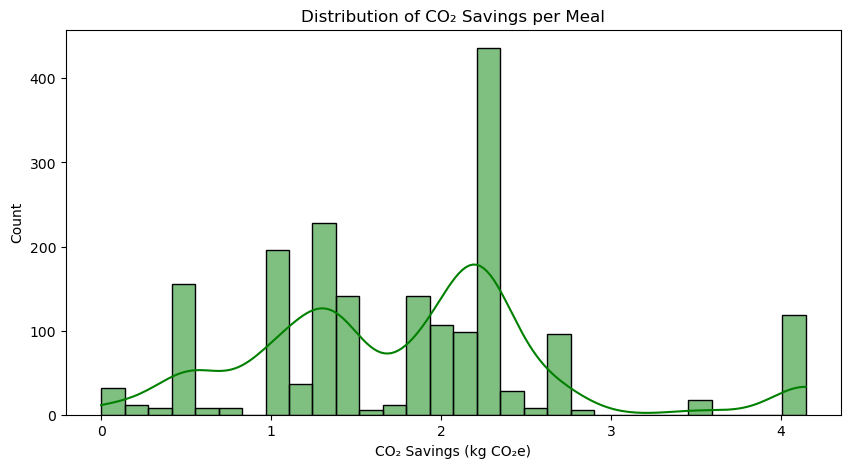

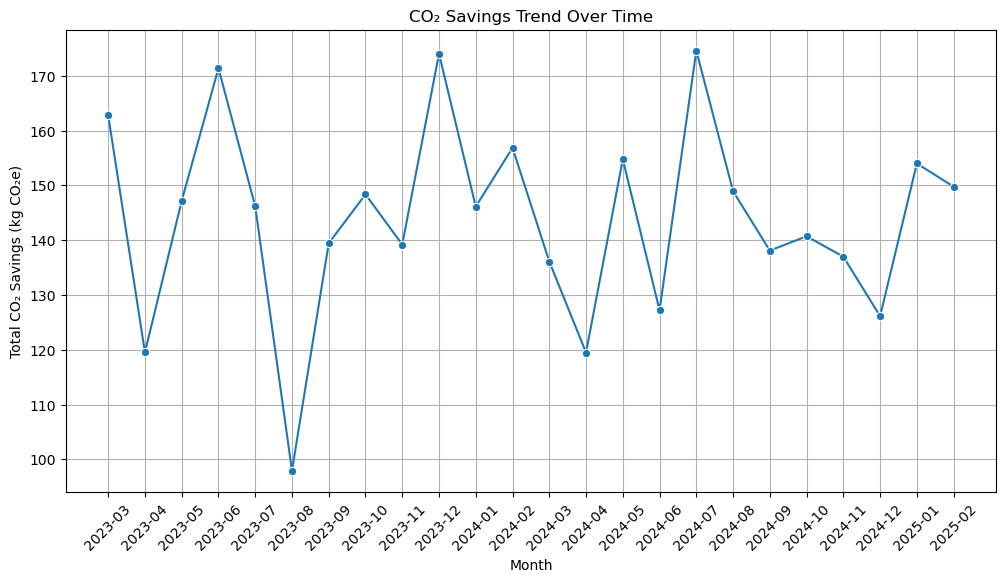

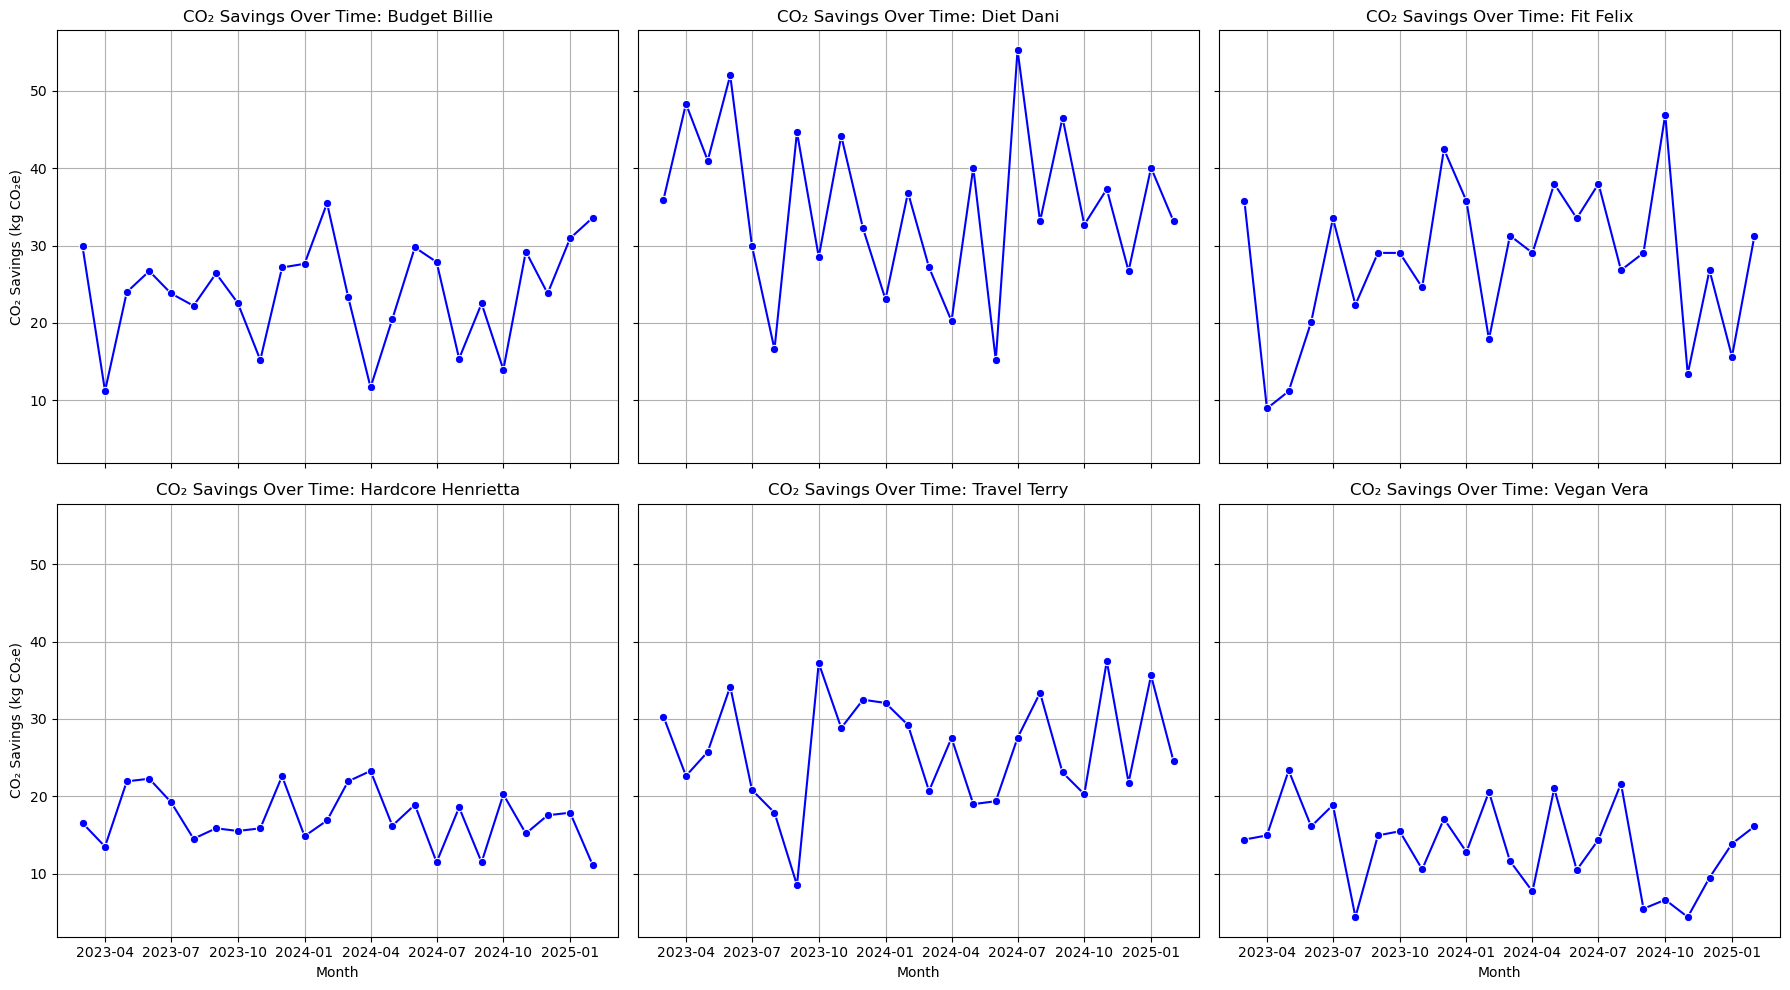

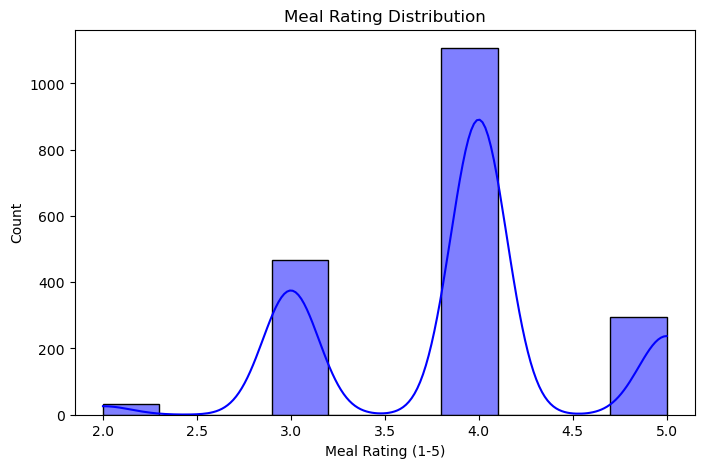

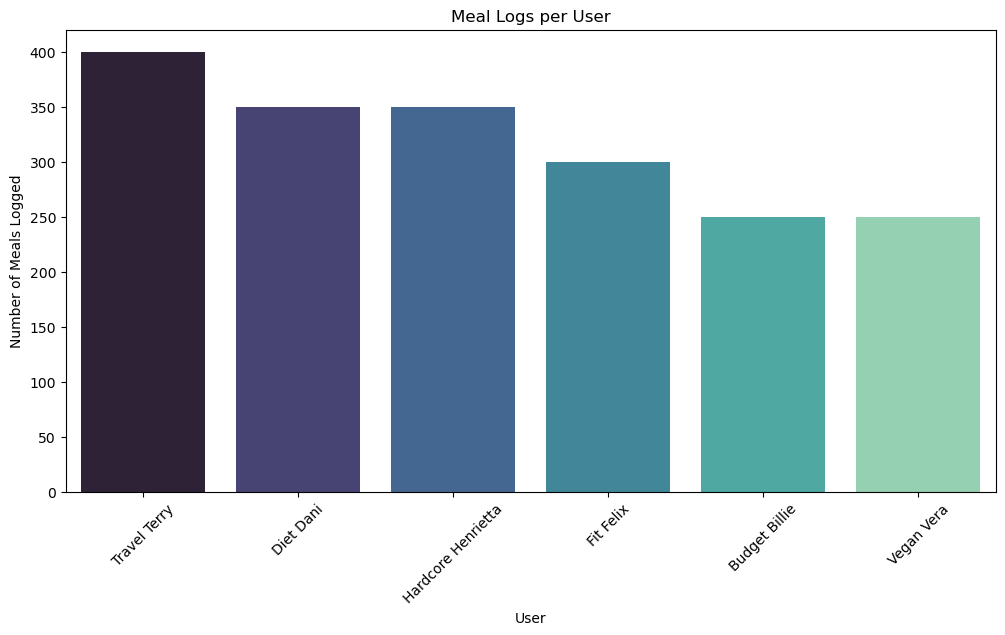

In [67]:
# ---------------------------
# 5. VISUALIZATIONS
# ---------------------------

# 🔹 CO₂ Savings Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_activity["carbon_savings"], bins=30, kde=True, color="green")
plt.title("Distribution of CO₂ Savings per Meal")
plt.xlabel("CO₂ Savings (kg CO₂e)")
plt.ylabel("Count")
plt.show()

# 🔹 CO₂ Savings Over Time

# Aggregate CO₂ savings per month
df_activity["activity_month"] = df_activity["activity_timestamp"].dt.to_period("M")
df_savings_per_month = df_activity.groupby("activity_month")["carbon_savings"].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_savings_per_month["activity_month"].astype(str), y=df_savings_per_month["carbon_savings"], marker="o")
plt.xticks(rotation=45)
plt.title("CO₂ Savings Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Total CO₂ Savings (kg CO₂e)")
plt.grid(True)
plt.show()

# 🔹 CO₂ Savings Over Time per user
# Aggregate CO₂ savings per month for each user
df_activity["activity_month"] = df_activity["activity_timestamp"].dt.to_period("M")
df_savings_per_user = df_activity.groupby(["user_id", "activity_month"])["carbon_savings"].sum().reset_index()

# Convert activity_month to datetime for plotting
df_savings_per_user["activity_month"] = pd.to_datetime(df_savings_per_user["activity_month"].astype(str))

# Get unique users
unique_users = df_savings_per_user["user_id"].unique()

# Set up subplots (2 rows, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharex=True, sharey=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Create a separate plot for each user
for i, user in enumerate(unique_users):
    user_data = df_savings_per_user[df_savings_per_user["user_id"] == user]
    sns.lineplot(ax=axes[i], x="activity_month", y="carbon_savings", data=user_data, marker="o", color="b")
    axes[i].set_title(f"CO₂ Savings Over Time: {user}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("CO₂ Savings (kg CO₂e)")
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# 🔹 Meal Rating Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_activity["meal_rating"], bins=10, kde=True, color="blue")
plt.title("Meal Rating Distribution")
plt.xlabel("Meal Rating (1-5)")
plt.ylabel("Count")
plt.show()

# 🔹 Count occurrences of each user
user_counts = df_activity["user_id"].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=user_counts.index, y=user_counts.values, hue=user_counts.index, palette="mako", legend=False)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.xlabel("User")
plt.ylabel("Number of Meals Logged")
plt.title("Meal Logs per User")
plt.show()


**Geographic Distribution of Meal Activities 🌍**

A world map visualizes meal locations based on user geolocation data.
This highlights regional differences in meal choices and CO₂ savings behavior.

In [68]:
# ---------------------------
# Visualization: World map of Geolocations
# ---------------------------

!pip install folium
import folium
from folium.plugins import HeatMap
import ast

# 🔹 VISUALIZATION: WORLD MAP OF GEOLOCATIONS

# Ensure 'geo_location' column exists
if "geo_location" not in df_activity.columns:
    raise KeyError("Column 'geo_location' not found in df_activity.")

# Check if the first value is a string, convert only if needed
if isinstance(df_activity["geo_location"].iloc[0], str):
    df_activity["geo_location"] = df_activity["geo_location"].apply(eval)

# Extract latitudes and longitudes
latitudes = df_activity["geo_location"].apply(lambda x: x[0])
longitudes = df_activity["geo_location"].apply(lambda x: x[1])

# Create a Folium map centered at the average location
map_center = [np.mean(latitudes), np.mean(longitudes)]
map_meal_activity = folium.Map(location=map_center, zoom_start=2)

# Add markers for each meal activity
for lat, lon in zip(latitudes, longitudes):
    folium.Marker(location=[lat, lon], popup="Meal Activity").add_to(map_meal_activity)

# Display the interactive map inside Jupyter Notebook
display(map_meal_activity)


## Introduction: Forecasting CO₂ Savings for a Sustainable Future
As the world moves toward more sustainable food consumption, reducing carbon emissions through ingredient substitutions has gained importance. By replacing animal-based ingredients with plant-based alternatives, individuals can significantly lower their environmental footprint. However, to understand the long-term impact of these choices, we need data-driven forecasts that estimate future CO₂ savings. 

This analysis aims to predict total CO₂ savings for 2025, using time-series forecasting models to identify trends and estimate potential emission reductions.

**Why SARIMAX Was Not Used**
Initially, SARIMAX (Seasonal ARIMA with Exogenous Variables) was considered, but:

The Augmented Dickey-Fuller (ADF) test confirmed that the time series is stationary (i.e., no significant trend or seasonality).
SARIMAX is most useful for non-stationary, seasonal time series, making it unnecessary for this dataset.

Instead, ARIMA (suited for stationary data) and XGBoost Regression (a machine learning model that detects complex patterns) were chosen.

**Model Selection & Forecasting Approach**

To ensure accurate CO₂ savings predictions, we tested multiple models:

- Baseline Models: Mean and trend-based forecasts for reference.

- ARIMA: Captures autoregressive and moving average patterns, ideal for stationary data.

- XGBoost Regression: A machine learning model optimized with hyperparameter tuning to find the best predictive performance.

**Key Insights & Applications**

The best-performing model was selected based on Mean Absolute Error (MAE), Mean Squared Error (MSE), and RMSE. Using this model, an extended forecast for 2025 was generated, providing insights into:


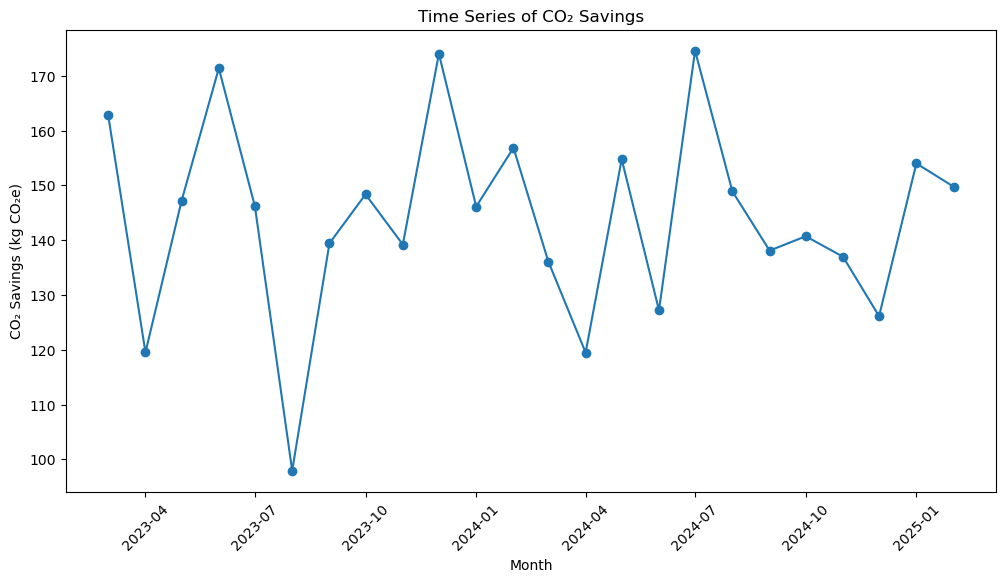

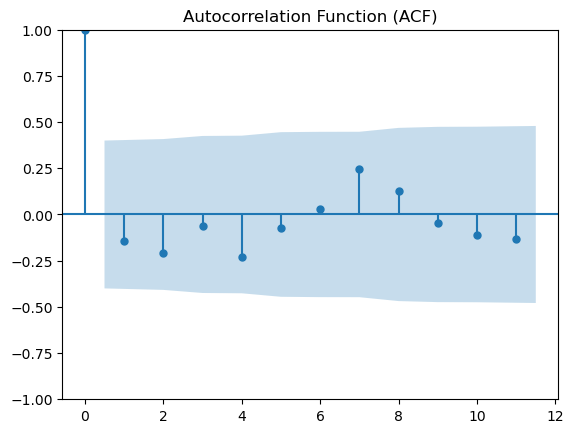

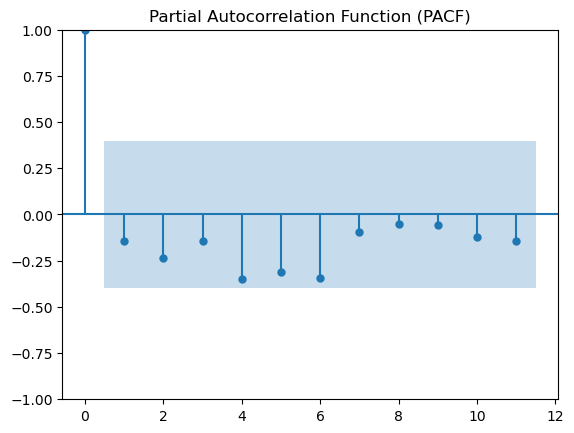

ADF Statistic: -3.9021846981406543
p-value: 0.0020188276311244847
The time series is stationary (no trend or seasonality). -> no SARIMAX Model
Bestes ARIMA-Modell: ARIMA(1,0,1)


In [69]:
# ---------------------------
# Total carbon footprint forecast
# ---------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


# **Exploratory Data Analysis: Visualizing Seasonality**
# First visualize the CO₂ savings time series to detect trends and seasonality.

# Ensure activity_month is in datetime format
df_savings_per_month["activity_month"] = df_savings_per_month["activity_month"].astype(str)
df_savings_per_month["activity_month"] = pd.to_datetime(df_savings_per_month["activity_month"])


plt.figure(figsize=(12, 6))
plt.plot(df_savings_per_month["activity_month"], df_savings_per_month["carbon_savings"], marker="o")
plt.xlabel("Month")
plt.ylabel("CO₂ Savings (kg CO₂e)")
plt.title("Time Series of CO₂ Savings")
plt.xticks(rotation=45)
plt.show()


# **Checking for Autocorrelation and Partial Autocorrelation**
# The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) help us determine the order of ARIMA models.
# Ensure that the number of lags does not exceed 50% of the sample size to avoid overfitting.
max_lags = min(24, (len(df_savings_per_month) // 2) - 1)

if max_lags > 1:
    plot_acf(df_savings_per_month["carbon_savings"], lags=max_lags)
    plt.title("Autocorrelation Function (ACF)")
    plt.show()

    plot_pacf(df_savings_per_month["carbon_savings"], lags=max_lags, method='ywm')
    plt.title("Partial Autocorrelation Function (PACF)")
    plt.show()
else:
    print("Too few data points for ACF and PACF analysis.")

# **Testing for Stationarity: Augmented Dickey-Fuller Test**
# A stationary time series has constant mean and variance, which is important for ARIMA models.
result = adfuller(df_savings_per_month["carbon_savings"])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < 0.05:
    print("The time series is stationary (no trend or seasonality). -> no SARIMAX Model")
else:
    print("The time series is not stationary (possible trend or seasonality present).")

# **Determining ARIMA Order (p, d, q) Based on ACF and PACF**
# - The ACF plot shows that most autocorrelations are within the confidence bounds, indicating that there is no strong moving average (MA) component. This suggests a small q.
# - Since the ADF test confirms stationarity (p-value < 0.05), **d = 0** is appropriate because no differencing is needed.


# **Splitting Data into Training and Test Sets**
# We use data before 2025 for training and data from 2025 onwards for testing.
train_data = df_savings_per_month[df_savings_per_month["activity_month"] < "2025-01-01"]
test_data = df_savings_per_month[df_savings_per_month["activity_month"] >= "2025-01-01"]

# **Creating Indexes for Models that Require Numeric Inputs**
train_index = np.arange(len(train_data))
test_index = np.arange(len(train_data), len(train_data) + len(test_data))

# **Baseline Models: Mean Forecast and Trend Forecast**
# The mean forecast assumes the future values will be the average of past values.
mean_forecast = np.full(len(test_data), train_data["carbon_savings"].mean())

# The mean forecast with trend considers the linear trend in the data.
slope = (train_data["carbon_savings"].values[-1] - train_data["carbon_savings"].values[0]) / len(train_data)
mean_trend_forecast = mean_forecast + slope * np.arange(len(test_data))

# **Finding the Best ARIMA Model**
# Test multiple ARIMA configurations and select the one with the lowest error.
arima_models = {
    "ARIMA(1,0,0)": (1,0,0),
    "ARIMA(2,0,0)": (2,0,0),
    "ARIMA(3,0,0)": (3,0,0),
    "ARIMA(1,0,1)": (1,0,1),
    "ARIMA(2,0,1)": (2,0,1),
    "ARIMA(3,0,1)": (3,0,1)
}

arima_results = {}
for name, order in arima_models.items():
    try:
        model = ARIMA(train_data["carbon_savings"], order=order, enforce_invertibility=False).fit()
        forecast = model.forecast(len(test_data))
        arima_results[name] = (forecast, mean_absolute_error(test_data["carbon_savings"], forecast))
    except Exception as e:
        print(f"Fehler bei {name}: {e}")

best_arima_name = min(arima_results, key=lambda x: arima_results[x][1])
best_arima_forecast = arima_results[best_arima_name][0]
print(f"Bestes ARIMA-Modell: {best_arima_name}")

## **XGBoost Regression Model** with Hyperparameter-Tuning
# XGBoost is a machine learning model optimized for structured data. It learns patterns from past observations.

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(train_index.reshape(-1, 1), train_data["carbon_savings"])

# Retrieve the best model from the grid search
best_xgb_model = grid_search.best_estimator_
xgb_forecast = best_xgb_model.predict(test_index.reshape(-1, 1))





**Analysis of CO₂ Savings Time Series and Model Selection**

1. Time Series Overview

The first plot illustrates the time series of CO₂ savings over time. The data exhibits fluctuations but does not show a clear trend or strong seasonality, indicating a stationary behavior. Peaks and drops suggest variations in meal choices or external factors influencing CO₂ savings.

2. Autocorrelation and Partial Autocorrelation Analysis

The Autocorrelation Function (ACF) plot shows that most lags fall within the confidence interval, meaning there is no strong long-term dependence in the data.

The Partial Autocorrelation Function (PACF) suggests a short-term correlation at lag 1, indicating that an AR(1) component might be relevant in the ARIMA model.

3. Stationarity Test (ADF Test)

The Augmented Dickey-Fuller (ADF) test confirms that the time series is stationary with a p-value of 0.002, which is below the significance threshold of 0.05. This means that:
- No differencing (d=0) is required.
- A SARIMAX model is unnecessary, as there is no seasonality in the data.

4. Model Selection: ARIMA(1,0,1)

Given the stationarity of the data and the insights from ACF/PACF, the best-performing model was determined to be ARIMA(1,0,1).

p = 1 (lag 1 is significant in PACF, indicating an autoregressive component).

d = 0 (no differencing required due to stationarity).

q = 1 (ACF suggests a minor moving average effect).


In [70]:
# **Model Evaluation**
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {"Model": model_name, "MAE": mae, "MSE": mse, "RMSE": rmse}

results = []
results.append(evaluate_model(test_data["carbon_savings"], mean_forecast, "Mean Forecast"))
results.append(evaluate_model(test_data["carbon_savings"], mean_trend_forecast, "Mean Forecast with Trend"))
results.append(evaluate_model(test_data["carbon_savings"], best_arima_forecast, best_arima_name))
results.append(evaluate_model(test_data["carbon_savings"], xgb_forecast, "XGBoost (Optimized)"))

df_results = pd.DataFrame(results)
print("\nModel evaluation for CO₂ savings forecasts:")
print(df_results)



Model evaluation for CO₂ savings forecasts:
                      Model        MAE         MSE       RMSE
0             Mean Forecast   8.610136   78.620372   8.866813
1  Mean Forecast with Trend   9.443795   90.834804   9.530729
2              ARIMA(1,0,1)   1.380758    2.531227   1.590983
3       XGBoost (Optimized)  12.682550  165.333003  12.858188


**Model Evaluation for CO₂ Savings Forecasts**

The table presents the performance comparison of different forecasting models based on three key error metrics:

Overall, ARIMA(1,0,1) was chosen as the final model due to its superior accuracy and stability in predicting future CO₂ savings. 


Extended forecast for the rest of 2025:
         Date  Extended Forecast
24 2025-03-01         144.108515
25 2025-04-01         143.988853
26 2025-05-01         143.943128
27 2025-06-01         143.925656
28 2025-07-01         143.918979
29 2025-08-01         143.916428
30 2025-09-01         143.915453
31 2025-10-01         143.915081
32 2025-11-01         143.914939
33 2025-12-01         143.914884


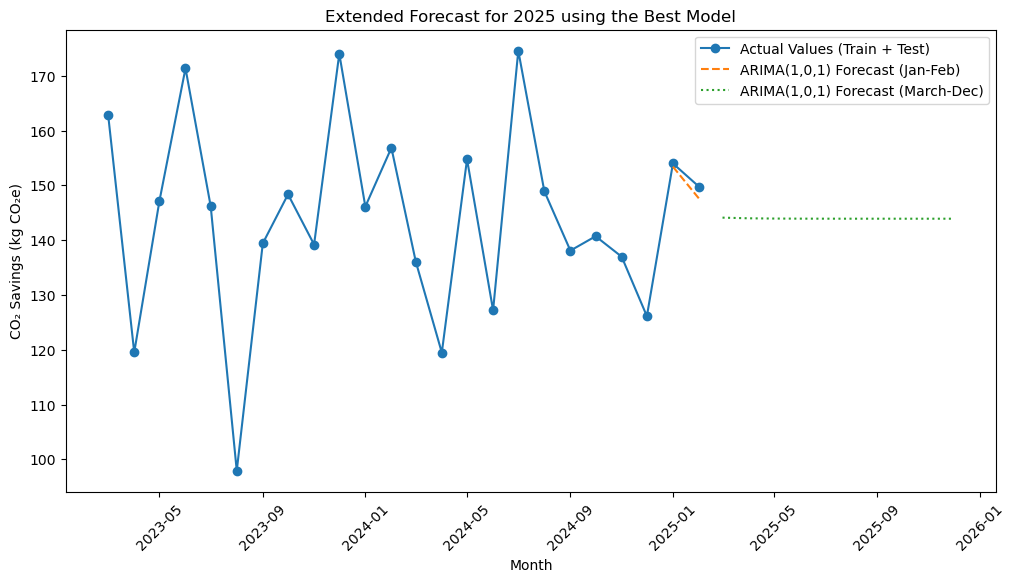

In [71]:
# Forecast for the remaining months of 2025 using the best model
test_periods = 12 - len(test_data)  # Number of remaining months in 2025
future_months = pd.date_range(start="2025-03-01", periods=test_periods, freq="MS")

if best_arima_name:
    best_model = ARIMA(df_savings_per_month["carbon_savings"], order=arima_models[best_arima_name]).fit()
    extended_forecast = best_model.forecast(steps=test_periods)
else:
    extended_forecast = np.full(test_periods, mean_forecast.mean())

# Print the extended forecast
print("\nExtended forecast for the rest of 2025:")
forecast_df = pd.DataFrame({
    "Date": future_months,
    "Extended Forecast": extended_forecast
})
print(forecast_df)

# Visualization of the extended forecast
plt.figure(figsize=(12, 6))
plt.plot(df_savings_per_month["activity_month"], df_savings_per_month["carbon_savings"], label="Actual Values (Train + Test)", marker="o")
plt.plot(test_data["activity_month"], best_arima_forecast, label=f"{best_arima_name} Forecast (Jan-Feb)", linestyle="dashed")
plt.plot(future_months, extended_forecast, label=f"{best_arima_name} Forecast (March-Dec)", linestyle="dotted")
plt.legend()
plt.xlabel("Month")
plt.ylabel("CO₂ Savings (kg CO₂e)")
plt.title("Extended Forecast for 2025 using the Best Model")
plt.xticks(rotation=45)
plt.show()


## Forecasting CO₂ Savings for Each User

To analyze individual CO₂ savings trends, we developed personalized time-series forecasts for each user based on their historical CO₂ savings data. This approach allows us to better understand how different users contribute to carbon footprint reduction over time and predict their future savings.

**Steps in the Analysis**

1. Data Aggregation & Preparation

CO₂ savings were aggregated per month per user to create individual time series.
The activity month was converted to a numerical index to serve as an input for forecasting models.

2. Forecasting Models for Each User

To generate accurate predictions, multiple forecasting models were tested for each user:

- Mean Forecast – Uses the historical average savings as a baseline prediction.
- ARIMA Models – Multiple ARIMA configurations were tested to capture autoregressive and moving average dependencies.
- XGBoost Regression – A machine learning approach with hyperparameter tuning to detect complex patterns in user behavior.

3. Model Selection Based on Error Metrics

Each model’s performance was evaluated using Mean Absolute Error (MAE), Mean Squared Error (MSE), and RMSE.

The best-performing model for each user was selected based on the lowest MAE.

4. Extended Forecast for 2025

The best model for each user was used to forecast CO₂ savings from March 2025 onward.
A time-series visualization was generated to visualize the savings in 2025 compared to the previous savings.


Processing User: Budget Billie
Best ARIMA Model for User Budget Billie: ARIMA(2,0,1)

Error Metrics for User Budget Billie:
  Mean Forecast: MAE=9.0671, MSE=83.9704, RMSE=9.1635
  ARIMA(2,0,1): MAE=6.0313, MSE=41.6361, RMSE=6.4526
  XGBoost: MAE=9.0378, MSE=83.4404, RMSE=9.1346

Best Model for User Budget Billie: ARIMA(2,0,1)

Processing User: Diet Dani
Best ARIMA Model for User Diet Dani: ARIMA(1,0,1)

Error Metrics for User Diet Dani:
  Mean Forecast: MAE=3.4590, MSE=14.8813, RMSE=3.8576
  ARIMA(1,0,1): MAE=1.7359, MSE=5.0578, RMSE=2.2489
  XGBoost: MAE=3.4590, MSE=18.8381, RMSE=4.3403

Best Model for User Diet Dani: ARIMA(1,0,1)

Processing User: Fit Felix
Best ARIMA Model for User Fit Felix: ARIMA(1,0,0)

Error Metrics for User Fit Felix:
  Mean Forecast: MAE=7.8225, MSE=84.9704, RMSE=9.2179
  ARIMA(1,0,0): MAE=7.8097, MSE=81.2424, RMSE=9.0135
  XGBoost: MAE=7.8225, MSE=79.4723, RMSE=8.9147

Best Model for User Fit Felix: ARIMA(1,0,0)

Processing User: Hardcore Henrietta
Best ARIMA

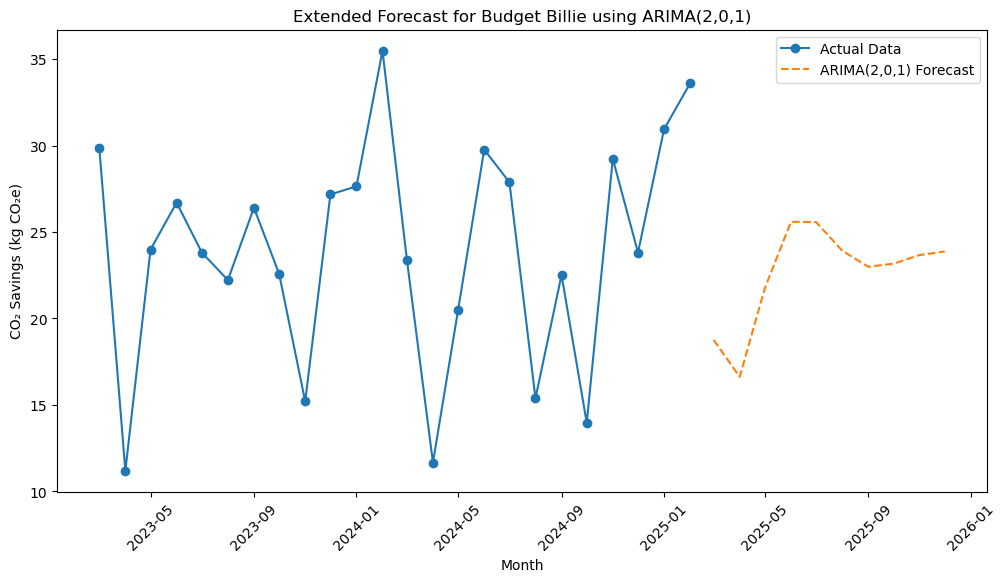

Extended Forecast for User Diet Dani:
       Month  Forecast using Best Model
0 2025-03-01                  35.492832
1 2025-04-01                  34.280070
2 2025-05-01                  34.858052
3 2025-06-01                  34.582596
4 2025-07-01                  34.713873


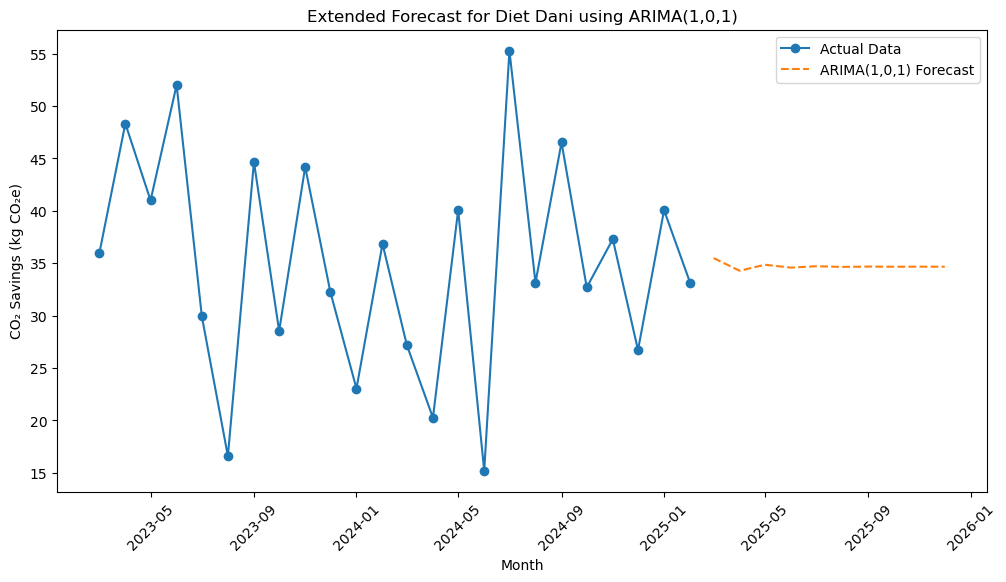

Extended Forecast for User Fit Felix:
       Month  Forecast using Best Model
0 2025-03-01                  27.625519
1 2025-04-01                  27.596049
2 2025-05-01                  27.595812
3 2025-06-01                  27.595810
4 2025-07-01                  27.595810


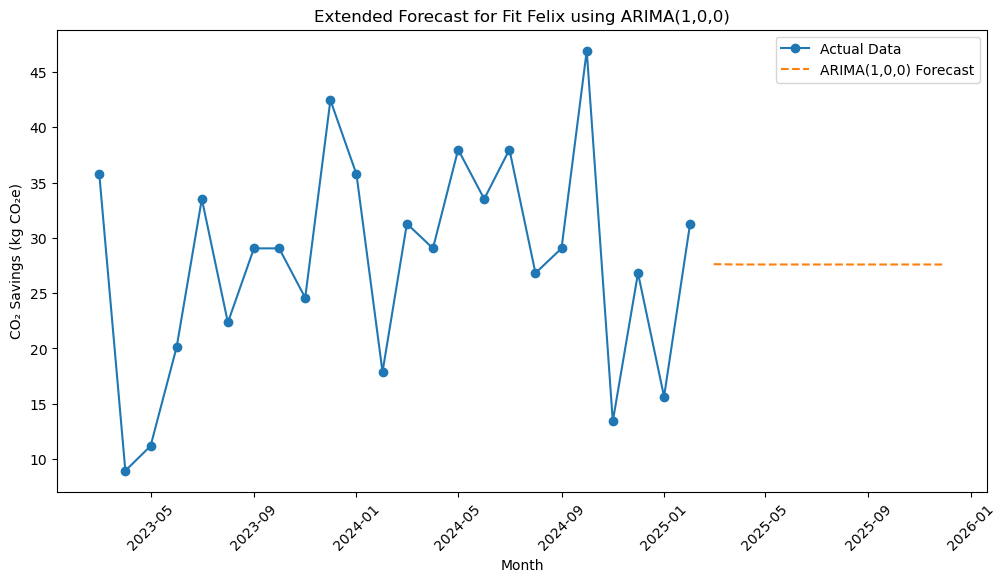

Extended Forecast for User Hardcore Henrietta:
       Month  Forecast using Best Model
0 2025-03-01                  17.215625
1 2025-04-01                  17.215625
2 2025-05-01                  17.215625
3 2025-06-01                  17.215625
4 2025-07-01                  17.215625


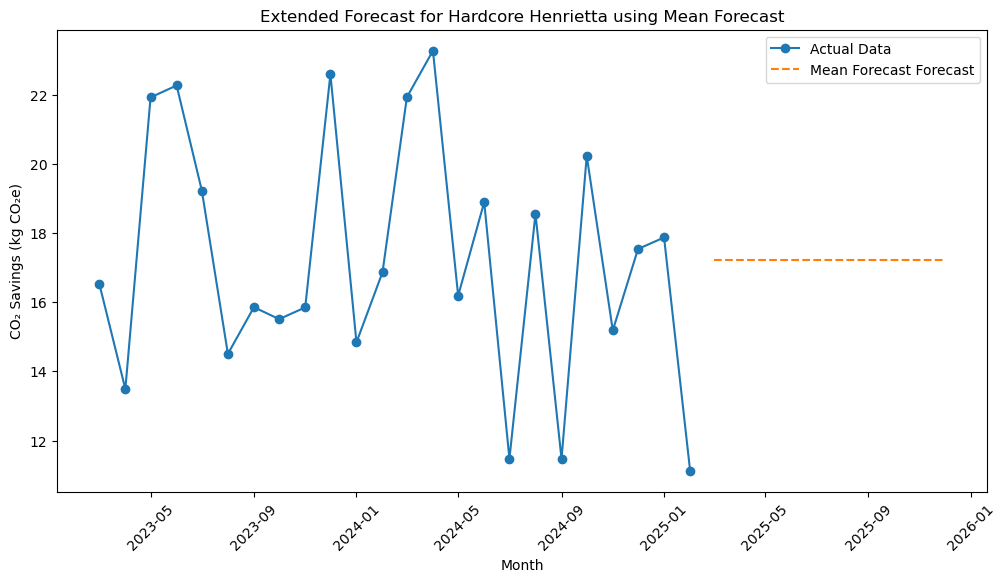

Extended Forecast for User Travel Terry:
       Month  Forecast using Best Model
0 2025-03-01                  23.372046
1 2025-04-01                  21.632887
2 2025-05-01                  24.168505
3 2025-06-01                  25.957772
4 2025-07-01                  27.442546


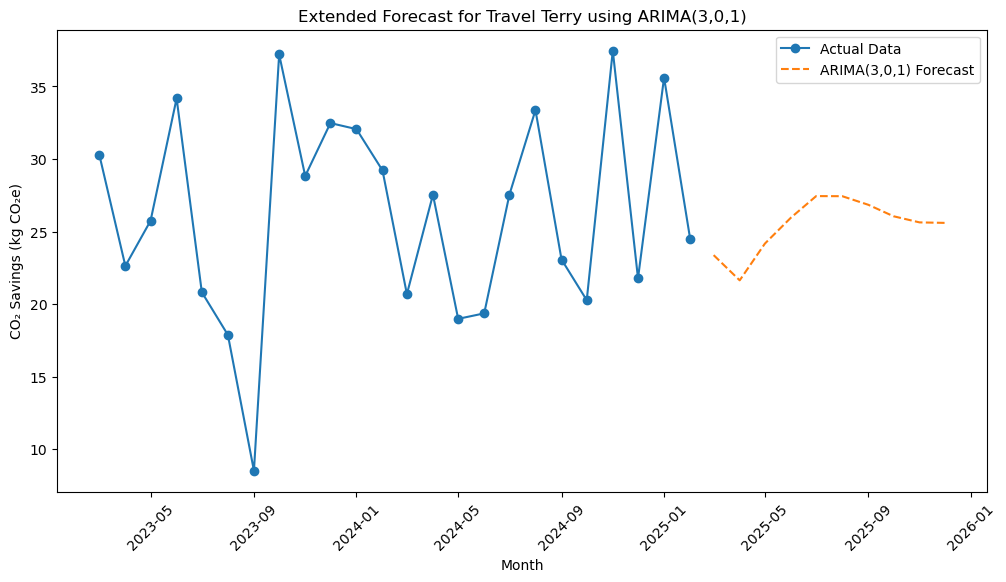

Extended Forecast for User Vegan Vera:
       Month  Forecast using Best Model
0 2025-03-01                  13.451274
1 2025-04-01                  13.205454
2 2025-05-01                  13.026575
3 2025-06-01                  12.896408
4 2025-07-01                  12.801688


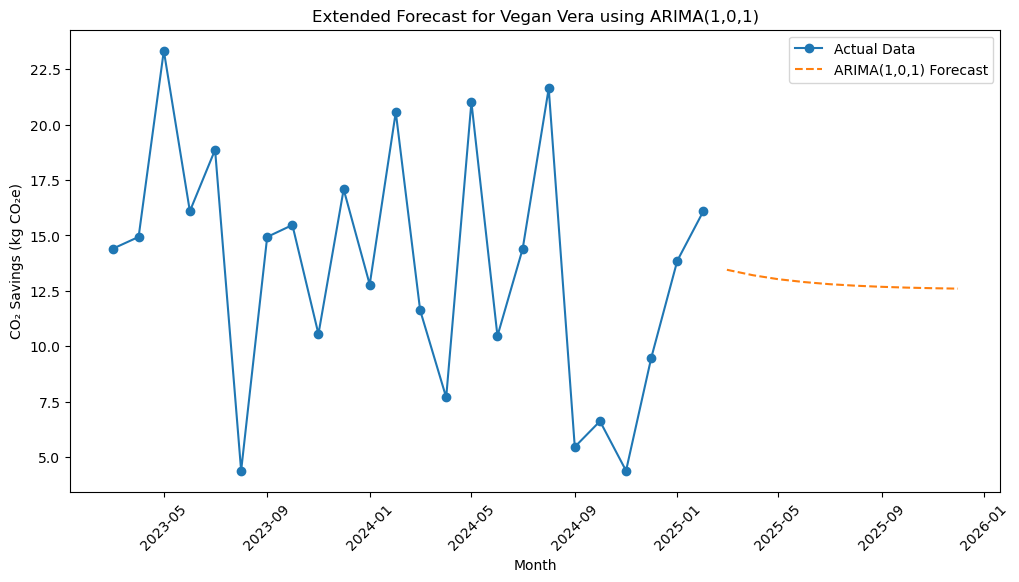

In [72]:
# ---------------------------
# Forecast for each person
# ---------------------------

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Aggregate CO₂ savings per month for each user
df_savings_per_user = df_activity.groupby(["user_id", "activity_month"])['carbon_savings'].sum().reset_index()

# Convert activity_month to datetime format
df_savings_per_user["activity_month"] = pd.to_datetime(df_savings_per_user["activity_month"].astype(str))

# Create an index for forecasting models
df_savings_per_user["month_index"] = df_savings_per_user["activity_month"].factorize()[0]

# Function to evaluate model errors
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {"Model": model_name, "MAE": mae, "MSE": mse, "RMSE": rmse}

# Generate predictions per user and select the best model
user_results = {}
best_models = {}
forecast_2025_results = {}

arima_models = {
    "ARIMA(1,0,0)": (1,0,0),
    "ARIMA(2,0,0)": (2,0,0),
    "ARIMA(3,0,0)": (3,0,0),
    "ARIMA(1,0,1)": (1,0,1),
    "ARIMA(2,0,1)": (2,0,1),
    "ARIMA(1,0,2)": (1,0,2),
    "ARIMA(3,0,1)": (3,0,1)
}

for user_id in df_savings_per_user["user_id"].unique():
    print(f"Processing User: {user_id}")
    user_data = df_savings_per_user[df_savings_per_user["user_id"] == user_id]
    train_data = user_data[user_data["activity_month"] < "2025-01-01"]
    test_data = user_data[(user_data["activity_month"] >= "2025-01-01") & (user_data["activity_month"] < "2025-03-01")]
    
    if len(train_data) == 0 or len(test_data) == 0:
        print(f"Skipping User {user_id}: Not enough data")
        continue
    
    # Mean Forecast
    mean_forecast = np.full(len(test_data), train_data["carbon_savings"].mean())
    
    # Test multiple ARIMA models
    arima_results = {}
    for name, order in arima_models.items():
        try:
            model = ARIMA(train_data["carbon_savings"].values, order=order, 
                          enforce_stationarity=False, enforce_invertibility=False).fit()
            forecast = model.forecast(len(test_data))
            arima_results[name] = (forecast, mean_absolute_error(test_data["carbon_savings"], forecast))
        except Exception as e:
            print(f"ARIMA {name} could not be trained: {e}")
            continue
    
    best_arima_name = min(arima_results, key=lambda x: arima_results[x][1]) if arima_results else None
    best_arima_forecast = arima_results[best_arima_name][0] if best_arima_name else np.full(len(test_data), mean_forecast.mean())
    print(f"Best ARIMA Model for User {user_id}: {best_arima_name}")
    
    # XGBoost Model with Hyperparameter Tuning
    xgb_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    grid_search = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='neg_mean_absolute_error')
    grid_search.fit(train_data["month_index"].values.reshape(-1, 1), train_data["carbon_savings"])
    best_xgb_model = grid_search.best_estimator_
    xgb_forecast = best_xgb_model.predict(test_data["month_index"].values.reshape(-1, 1))
     
  # Evaluate Errors
    errors = {
        "Mean Forecast": evaluate_model(test_data["carbon_savings"], mean_forecast, "Mean Forecast"),
        best_arima_name: evaluate_model(test_data["carbon_savings"], best_arima_forecast, best_arima_name) if best_arima_name else None,
        "XGBoost": evaluate_model(test_data["carbon_savings"], xgb_forecast, "XGBoost")
    }
    
    print(f"\nError Metrics for User {user_id}:")
    for model, metrics in errors.items():
        if metrics:
            print(f"  {model}: MAE={metrics['MAE']:.4f}, MSE={metrics['MSE']:.4f}, RMSE={metrics['RMSE']:.4f}")
    
    best_model = min(errors, key=lambda x: errors[x]["MAE"] if errors[x] else float('inf'))
    best_models[user_id] = best_model
    user_results[user_id] = errors
    print(f"\nBest Model for User {user_id}: {best_model}\n")



# Extended Forecast for Each User in 2025
for user_id, best_model in best_models.items():
    user_data = df_savings_per_user[df_savings_per_user["user_id"] == user_id]
    train_data = user_data[user_data["activity_month"] < "2025-03-01"]
    future_months = pd.date_range(start="2025-03-01", periods=10, freq="MS")
    future_indices = np.arange(len(train_data), len(train_data) + len(future_months))
    
    if best_model == "Mean Forecast":
        forecast = np.full(len(future_months), train_data["carbon_savings"].mean())
    elif best_model in arima_models:
        arima_model = ARIMA(train_data["carbon_savings"].values, order=arima_models[best_model], 
                             enforce_stationarity=False, enforce_invertibility=False).fit()
        forecast = arima_model.forecast(len(future_months))
    else:
        best_xgb_model.fit(train_data["month_index"].values.reshape(-1, 1), train_data["carbon_savings"])
        forecast = best_xgb_model.predict(future_indices.reshape(-1, 1))
    
    forecast_2025_results[user_id] = pd.DataFrame({
        "Month": future_months,
        "Forecast using Best Model": forecast
    })
    print(f"Extended Forecast for User {user_id}:")
    print(forecast_2025_results[user_id].head())
 
# Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(train_data["activity_month"], train_data["carbon_savings"], label="Actual Data", marker="o")
    plt.plot(future_months, forecast, label=f"{best_model} Forecast", linestyle="dashed")
    plt.legend()
    plt.xlabel("Month")
    plt.ylabel("CO₂ Savings (kg CO₂e)")
    plt.title(f"Extended Forecast for {user_id} using {best_model}")
    plt.xticks(rotation=45)
    plt.show()
    


## Conclusion

This analysis demonstrates the power of data-driven forecasting in evaluating the CO₂ impact of shifting from meat-based meals to plant-based alternatives. By applying time-series models to historical CO₂ savings data, we evaluated different forecasting approaches, and selected the most accurate models for both overall savings and individual user contributions. 

The results confirm that ARIMA(1,0,1) provides the most reliable predictions, while machine learning approaches like XGBoost proved less effective for this specific time series.

By extending the forecast into 2025, we gain valuable insights into how CO₂ savings might evolve over time. These predictions could encourage the users to change more meals and maximize carbon footprint reductions.